# Loading in the Data

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
with open('newgrid.data', 'rb') as f:
    new_data = pickle.load(f)

First, we will plot the Albany County heatmap obtained by using our supervised learning demand model. 

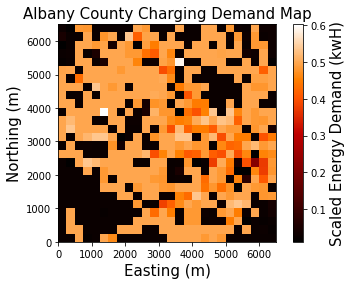

In [4]:
# Plotting the grid
plt.imshow(new_data, cmap='gist_heat',interpolation="nearest", extent=[0, 6500, 0, 6500])
plt.rcParams["figure.figsize"] = (10,10)
params = dict(fontsize=15)
plt.title('Albany County Charging Demand Map', fontdict=params)
plt.xlabel('Easting (m)', fontdict=params)
plt.ylabel('Northing (m)', fontdict=params)
cbar = plt.colorbar()
cbar.set_label('Scaled Energy Demand (kwH)', fontdict=params)
plt.grid(False)

plt.show()

In [5]:
best_actions_list = [] #compiles best possible actions
best_demands_list = []

new_list = []
for arr in new_data:
    for x in arr:
        new_list.append(x)

new_list.sort()
min_single_demand = new_list[0]
minimum = 0
for x in range(0, 10):
    minimum += new_list[x]

new_list.sort(reverse=True)
max_single_demand = new_list[0]
maximum = 0
for x in range(0, 10):
    maximum += new_list[x]
for x in range(0, 10):
    best_demands_list.append(new_list[x])

for i in range(len(new_data)):
    for j in range(len(new_data[0])):
        if (best_demands_list.__contains__(new_data[i][j])):
            best_actions_list.append([i, j])

maximum

5.4811060428619385

# Creating an Environment with OpenAI Gym

We adapted code by Nicholas Renotte to create our environment. We make use of OpenAI Gym. 

In [5]:
from gym import Env
from gym import spaces
import random
import math
from copy import deepcopy

Our environment consists of a number of methods that determine the reward obtained by placing a charger in a hypothetical location. 

In [237]:
MAIN_GRID = deepcopy(new_data)
GRID_SIZE = len(new_data)
NUM_CHARGERS = 10
MAX_DEMAND = maximum
MIN_DEMAND = minimum
MAX_SINGLE_DEMAND = max_single_demand
MIN_SINGLE_DEMAND = min_single_demand
COVER_SIZE = 2
MIN_COVERAGE = ((2 * COVER_SIZE) + 1) ** 2 + 1
MAX_COVERAGE = MIN_COVERAGE * NUM_CHARGERS # if >= 676, manually change max = 676
STATION_COST = 1852
TOTAL_BUDGET = NUM_CHARGERS * STATION_COST
COVERAGE_WEIGHT = 1
DEMAND_WEIGHT = 2
all_actions_list = []
all_rewards_list= []


class ChargeEnv(Env):   
    def __init__(self):    
        self.action_space = spaces.Discrete(GRID_SIZE * GRID_SIZE) 
        self.observation_space = spaces.Box(low=np.array([0]), high=np.array([MAX_DEMAND + MAX_COVERAGE]))
        self.state = 0 
        self.total_demand = 0
        self.total_coverage = 0
        self.COVER_GRID = np.zeros([GRID_SIZE, GRID_SIZE])
        self.actions_list = []
        self.budget = TOTAL_BUDGET
        self.EPISODE_COUNT = 0
        self.reward_list = []

    def reset_EP_COUNT(self):
        self.EPISODE_COUNT = 0
        
    def get_demand(self, action): 
        demand_value = MAIN_GRID[action // GRID_SIZE][action % GRID_SIZE]
        #reduce demand at nearby locations 
        radius = 2 #determines size of region that demand decreases 
        decrease_factor = 2 #determines factor by which the central square decreases in demand
        for i in range((action // GRID_SIZE) - radius, (action // GRID_SIZE) + radius + 1):
            for j in range((action % GRID_SIZE) - radius, (action % GRID_SIZE) + radius + 1):
                if self.inbounds(i, j):
                    dist = math.sqrt(((i - (action // GRID_SIZE)) ** 2) + ((j - (action % GRID_SIZE)) ** 2)) + decrease_factor
                    reduction_factor = 1-1 / dist #factor by which a particular square decreases in demand
                    MAIN_GRID[action // GRID_SIZE][action % GRID_SIZE] *= reduction_factor 
        return demand_value
    
    def inbounds(self, x, y): #checks if (x,y) is within the bounds of the grid
        return x >= 0 and x < len(self.COVER_GRID) and y >= 0 and y < len(self.COVER_GRID[0])

    def update_coverages(self, action):
        total = 0 if self.COVER_GRID[action // GRID_SIZE][action % GRID_SIZE] == 2 else 2
        self.COVER_GRID[action // GRID_SIZE][action % GRID_SIZE] = 2 
        # Update cells that aren't covered
        for i in range((action // GRID_SIZE) - COVER_SIZE, (action // GRID_SIZE) + COVER_SIZE + 1): 
            for j in range((action % GRID_SIZE) - COVER_SIZE, (action % GRID_SIZE) + COVER_SIZE + 1): 
                if self.inbounds(i, j):
                    if self.COVER_GRID[i][j] == 0: 
                        self.COVER_GRID[i][j] = 1
                        total += 1
        return total
    
    def get_reward(self, action):
        reward = 0
        demand = 0
        if self.COVER_GRID[action // GRID_SIZE][action % GRID_SIZE] != 2: 
            demand = self.get_demand(action)
            demand = float((demand - MIN_SINGLE_DEMAND)) / float((MAX_SINGLE_DEMAND - MIN_SINGLE_DEMAND)) # get rid of scaling? (already scaled)
            self.total_demand += self.get_demand(action)
            new_coverage = float(self.update_coverages(action)) / float(MIN_COVERAGE)
            reward = DEMAND_WEIGHT * demand + COVERAGE_WEIGHT * new_coverage
        else:
            reward = -1
        return reward

    def get_coverage(self):
        total = 0
        for row in self.COVER_GRID:
            for x in row:
                total += x
        return total
        
    def step(self, action):
        # Calculate reward
        self.actions_list.append([action // GRID_SIZE, action % GRID_SIZE])
        reward = self.get_reward(action)
        self.reward_list.append(reward)
        
        self.total_coverage = self.get_coverage()
        self.state = 0.5 * (MAX_DEMAND - self.total_demand) + 0.5 * (MAX_COVERAGE - self.total_coverage)
        self.budget -= STATION_COST
        
        if self.budget <= 0: 
            # intervals of data collection
            done = True
            if self.EPISODE_COUNT % 100 == 0:
                all_actions_list.append(self.actions_list)
            if self.EPISODE_COUNT % 25 == 0:
                all_rewards_list.append(self.reward_list)
            self.EPISODE_COUNT += 1
        else:
            done = False

        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        self.reward_list = []
        self.state = 0
        self.total_coverage = 0
        self.total_demand = 0
        self.COVER_GRID = np.zeros([GRID_SIZE, GRID_SIZE])
        self.budget = TOTAL_BUDGET
        self.actions_list = []
        MAIN_GRID = deepcopy(new_data) #if changing demand
        return self.state

# ! RUN THIS CELL !

In [238]:
# Reset Env
env = ChargeEnv()
env.reset_EP_COUNT()
all_actions_list = []
all_rewards_list= []

# Create DQN Model with Keras

In [239]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [240]:
states = env.observation_space.shape
actions = env.action_space.n

In [241]:
def build_model(states, actions):
    inputs = Input(shape=states) 
    layer1 = Dense(300, activation='relu')(inputs)
    layer2 = Dense(256, activation='relu')(layer1)
    action = Dense(actions, activation='linear')(layer2)
    return Model(inputs=inputs, outputs=action)

### uncomment/recomment this cell for every trial

In [242]:
del model 

In [243]:
model = build_model(states, actions)

In [244]:
model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               600       
_________________________________________________________________
dense_31 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_32 (Dense)             (None, 676)               173732    
Total params: 251,388
Trainable params: 251,388
Non-trainable params: 0
_________________________________________________________________


# Train DQN Agent

In [245]:
from rl.agents import DQNAgent 
from rl.policy import EpsGreedyQPolicy
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [246]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                nb_actions=actions, nb_steps_warmup=50, target_model_update=1e-2)
    return dqn

In [247]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mse'])

dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: 0.7479
1000 episodes - episode_reward: 7.479 [1.477, 14.991] - loss: 0.445 - mse: 24.237 - mean_q: 10.056

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: 0.7490
1000 episodes - episode_reward: 7.490 [3.034, 10.380] - loss: 0.398 - mse: 45.398 - mean_q: 10.999

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: 0.7544
1000 episodes - episode_reward: 7.544 [3.611, 10.034] - loss: 0.474 - mse: 49.098 - mean_q: 10.234

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: 0.7590
1000 episodes - episode_reward: 7.590 [4.284, 10.154] - loss: 0.320 - mse: 58.490 - mean_q: 10.200

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: 0.7631
done, took 427.

## Save weights for DQN model. If one of the models performs really well, then save the weights with this line.

In [248]:
# dqn.save_weights('dqn_weights.h5f', overwrite=True)

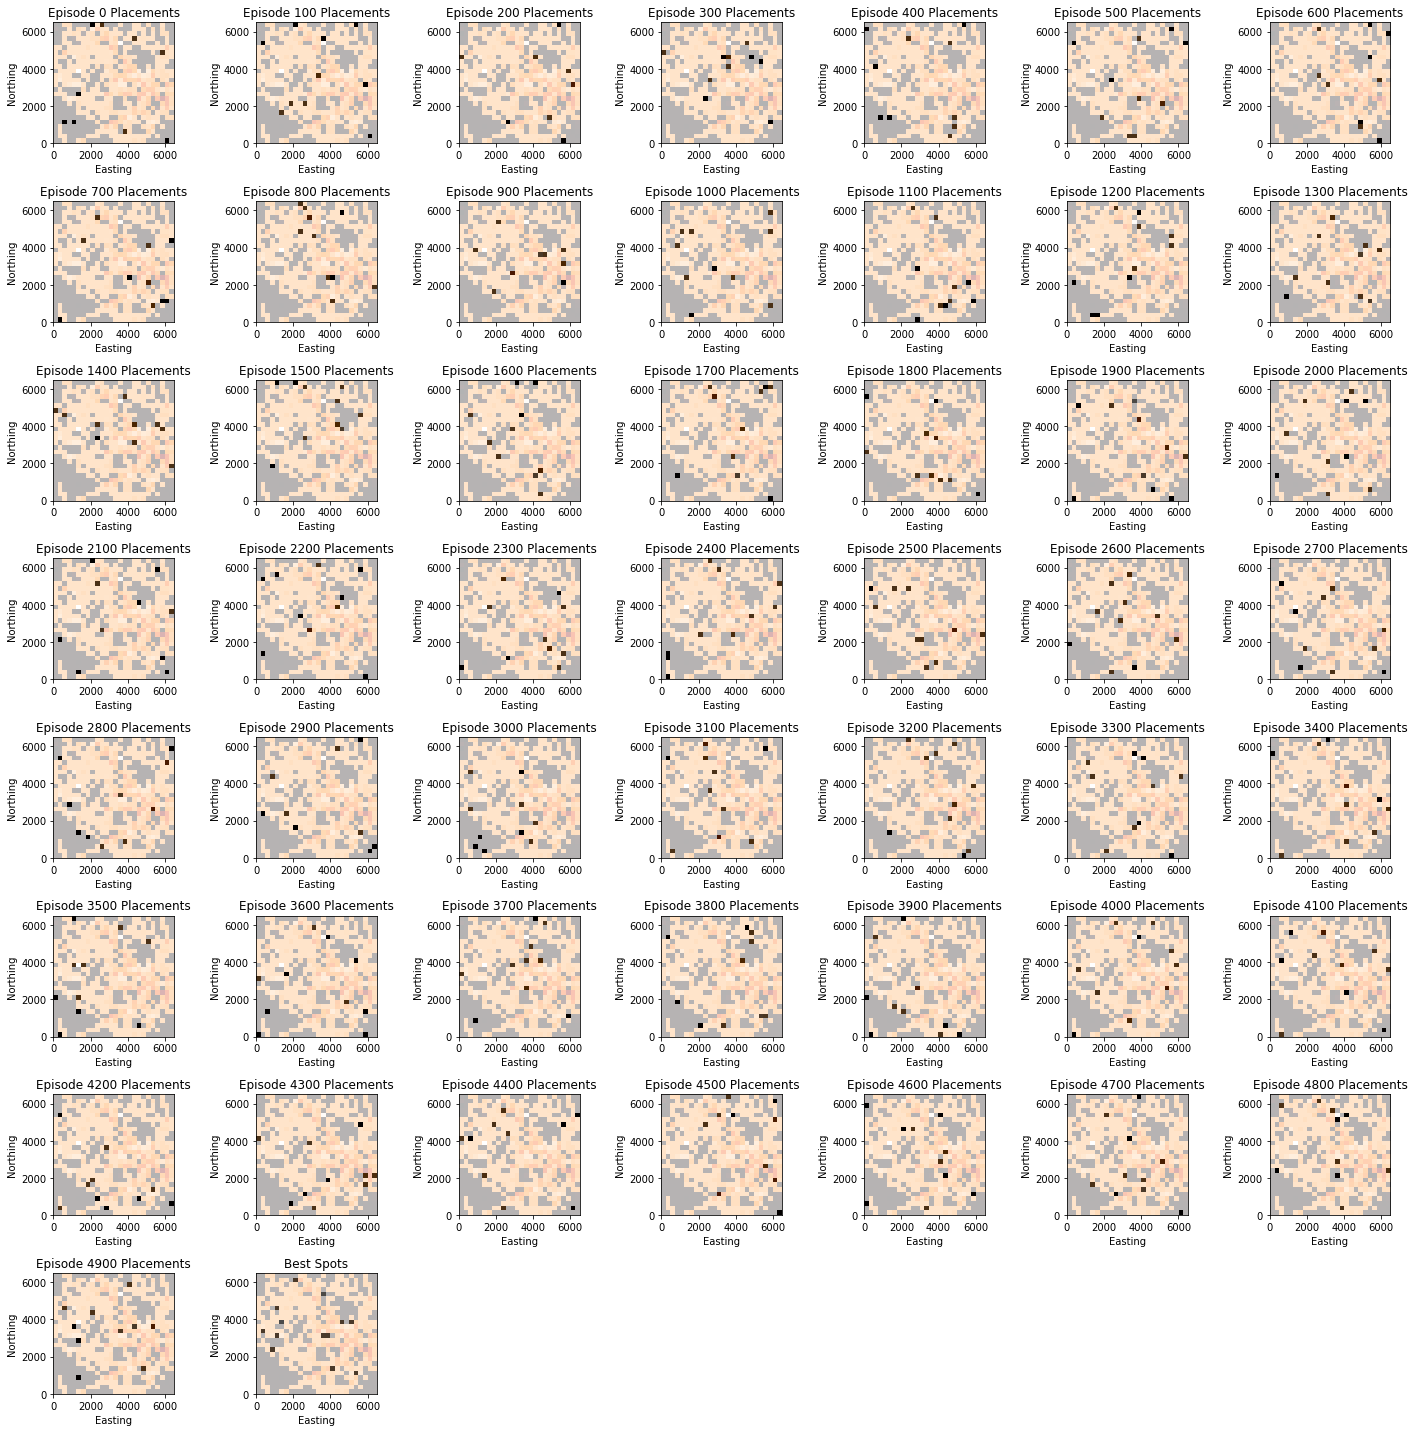

In [249]:
VIZ_GRID = np.zeros([GRID_SIZE, GRID_SIZE])

f = plt.figure(figsize=(20, 20))

for i in range(len(all_actions_list)):
    ax = f.add_subplot(8, 7, i + 1)
    #ax.set_title(f"Episode {i}")
    ep = all_actions_list[i]
    for point in ep:
        VIZ_GRID[point[0]][point[1]] = 1
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title(f"Episode {i * 100} Placements")
    ax.imshow(VIZ_GRID, cmap='binary', interpolation='nearest', extent=[0, 6500, 0, 6500])
    ax.imshow(new_data, cmap='gist_heat', interpolation='nearest', extent=[0, 6500, 0, 6500], alpha=0.3)
    VIZ_GRID = np.zeros([26, 26])

ax2 = f.add_subplot(8, 7, len(all_actions_list) + 1)
ax2.set_xlabel('Easting')
ax2.set_ylabel('Northing')
ax2.set_title('Best Spots')
for action in best_actions_list:
    VIZ_GRID[action[0]][action[1]] = 1
ax2.imshow(VIZ_GRID, cmap='binary', interpolation='nearest', extent=[0, 6500, 0, 6500])
ax2.imshow(new_data, cmap='gist_heat', interpolation='nearest', extent=[0, 6500, 0, 6500], alpha=0.3)

f.tight_layout()
VIZ_GRID = np.zeros([GRID_SIZE, GRID_SIZE])

# Save placements (**Change file name for each run and save separately)

In [250]:
f.savefig('placements_baselinedf5_ithink.png')

# Plot episodic rewards

Text(0, 0.5, 'Total Reward')

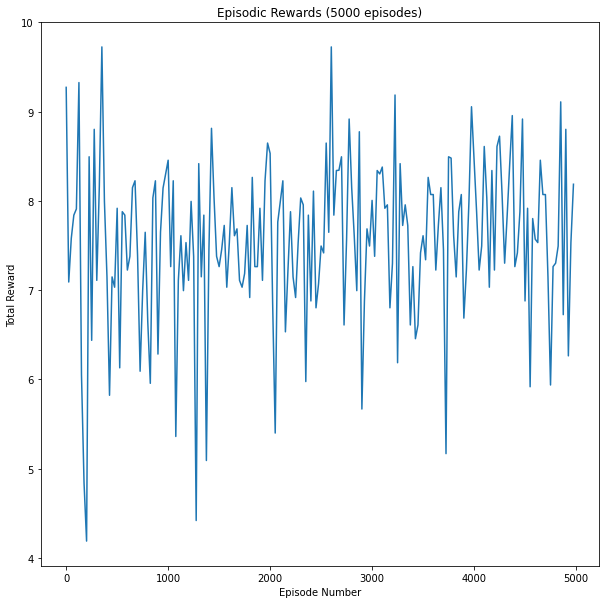

In [251]:
num_episodes = 5000
mean_rewards = []
ep_nums = []
for ep in all_rewards_list:
    mean_rewards.append(sum(ep))

tempindex = 0
while tempindex < num_episodes:
    ep_nums.append(tempindex)
    tempindex += 25

plt.plot(ep_nums, mean_rewards)
plt.title(f'Episodic Rewards ({num_episodes} episodes)')
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')

# Save figure as png below OR take a screenshot

In [252]:
#plt.savefig('rewards_coverage_4_demand_3.png', bbox_inches='tight')

# Max Mean Episodic Reward

In [253]:
max(mean_rewards)

9.725791380954668

# Testing "Good" Agent
### Actions are engineered.

In [254]:
len(best_actions_list)

13

In [255]:
import itertools

In [256]:
maxi = -100
random_env = ChargeEnv()

for x_list in list(itertools.combinations(best_actions_list, 10)):
    random_env.reset()
    random_env.reset_EP_COUNT()
    total_sc = 0
    for i in range (len(x_list)):
        n_state, reward, done, info = random_env.step((x_list[i][0]) * 26 + x_list[i][1])
        total_sc += reward
    if total_sc > maxi:
        print(str(x_list) + 'combinations: ' + str(total_sc))
        maxi = total_sc

([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 4], [13, 14], [13, 15])combinations: 7.033049115465859
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 4], [13, 14], [16, 3])combinations: 7.494587686240118
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 4], [13, 14], [20, 16])combinations: 7.84074142315814
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 4], [20, 16], [21, 21])combinations: 7.917664500081217
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 14], [16, 3], [20, 16])combinations: 8.263818346235063
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [12, 1], [13, 14], [20, 16], [21, 21])combinations: 8.37920296161968
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [10, 20], [13, 14], [16, 3], [20, 16], [21, 21])combinations: 8.686895269311986
([1, 8], [4, 14], [7, 4], [10, 5], [10, 18], [12, 1], [13, 14], [16, 3], [20, 16], [21, 21])combinations: 8.8022798846966
([1, 8], [4

In [232]:
decent_list = [[5, 7], [7, 17], [10, 5], [11, 15], [1, 22], [15, 10], [7, 23], [20, 9], [20, 24], [25, 15]]
#decent_list = [[5, 7], [7, 17], [10, 5], [11, 15], [15, 18], [15, 10], [17, 23], [20, 21], [20, 24], [25, 15]]

In [233]:
random_env = ChargeEnv()

total_sc = 0
for i in range (len(decent_list)):
    n_state, reward, done, info = random_env.step((decent_list[i][0]) * 26 + decent_list[i][1])
    total_sc += reward
print(total_sc)

8.917664500081218


# Testing Random Agent

In [236]:
random_env = ChargeEnv()
episodes = 100
total_scores = 0

for episode in range(1, episodes+1):
    state = random_env.reset()
    done = False
    score = 0 
    
    while not done:
        action = random_env.action_space.sample()
        n_state, reward, done, info = random_env.step(action)
        score += reward
    total_scores += score

print('Mean score: ' + str(total_scores / episodes))

Mean score: 7.543435998858696
